In [1]:
import collections
import nest_asyncio

import numpy as np
import tensorflow as tf
import tensorflow_federated as tff
from matplotlib import pyplot as plt

/usr/local/lib/python3.6/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:44: UserWarning: You are currently using a nightly version of TensorFlow (2.4.0-dev20200730). 
TensorFlow Addons offers no support for the nightly versions of TensorFlow. Some things might work, some other might not. 
If you encounter a bug, do not file an issue on GitHub.
  UserWarning,


In [2]:
nest_asyncio.apply()

In [3]:
tff.federated_computation(lambda: 'Hello, World!')()

b'Hello, World!'

### Prepping Input Data

Federated Datasets are non-iid, we will load them now

The data sets returned by load_data() are instances of tff.simulation.ClientData, an interface that allows us to enumerate the set of users, to construct a tf.data.Dataset that represents the data of a particular user, and to query the structure of individual elements. 

In [4]:
emnist_train, emnist_test = tff.simulation.datasets.emnist.load_data()

In [5]:
len(emnist_train.client_ids)

3383

In [6]:
emnist_train.element_type_structure

OrderedDict([('label', TensorSpec(shape=(), dtype=tf.int32, name=None)),
             ('pixels',
              TensorSpec(shape=(28, 28), dtype=tf.float32, name=None))])

In [7]:
example_dataset = emnist_train.create_tf_dataset_for_client(
    emnist_train.client_ids[0])

example_element = next(iter(example_dataset))

example_element['label'].numpy()

5

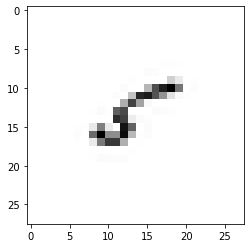

In [8]:
plt.imshow(example_element['pixels'].numpy(), cmap = 'gray', aspect = 'equal')
plt.grid(False)
_ = plt.show()

### Preprocessing

In [9]:
NUM_CLIENTS = 10
NUM_EPOCHS = 5
BATCH_SIZE = 20
SHUFFLE_BUFFER = 100
PREFETCH_BUFFER = 10

def preprocess(dataset):

  def batch_format_fn(element):
    """Flatten a batch `pixels` and return the features as an `OrderedDict`."""
    return collections.OrderedDict(
        x = tf.reshape(element['pixels'], [-1, 784]),
        y = tf.reshape(element['label'], [-1, 1]))

  return dataset.repeat(NUM_EPOCHS).shuffle(SHUFFLE_BUFFER).batch(
      BATCH_SIZE).map(batch_format_fn).prefetch(PREFETCH_BUFFER)

In [10]:
preprocessed_example_dataset = preprocess(example_dataset)

sample_batch = tf.nest.map_structure(lambda x: x.numpy(),
                                     next(iter(preprocessed_example_dataset)))

sample_batch

OrderedDict([('x', array([[1., 1., 1., ..., 1., 1., 1.],
                     [1., 1., 1., ..., 1., 1., 1.],
                     [1., 1., 1., ..., 1., 1., 1.],
                     ...,
                     [1., 1., 1., ..., 1., 1., 1.],
                     [1., 1., 1., ..., 1., 1., 1.],
                     [1., 1., 1., ..., 1., 1., 1.]], dtype=float32)),
             ('y', array([[9],
                     [6],
                     [1],
                     [1],
                     [1],
                     [0],
                     [7],
                     [1],
                     [2],
                     [6],
                     [7],
                     [1],
                     [8],
                     [9],
                     [9],
                     [1],
                     [7],
                     [0],
                     [0],
                     [4]], dtype=int32))])

In [11]:
def make_federated_data(client_data, client_ids):
  return [
      preprocess(client_data.create_tf_dataset_for_client(x))
      for x in client_ids
  ]

### Random Sampling

In [12]:
sample_clients = emnist_train.client_ids[0:NUM_CLIENTS]

federated_train_data = make_federated_data(emnist_train, sample_clients)

print('Number of client datasets: {l}'.format(l = len(federated_train_data)))
print('First dataset: {d}'.format(d = federated_train_data[0]))

Number of client datasets: 10
First dataset: <PrefetchDataset shapes: OrderedDict([(x, (None, 784)), (y, (None, 1))]), types: OrderedDict([(x, tf.float32), (y, tf.int32)])>


### Create Model